# 10.6 Geospatial data

*Estimated time for this notebook: 10 minutes.*

Many domains have their own widely-used data file formats, which are optimized for their own most common use-cases.   For example, geospatial datasets will often have some "coordinates" (e.g. Latitude and Longitude, and possibly Time), and a set of measurements at each point (e.g. Temperature, Humidity, Wind Speed).   Storing such data in a simple table, such as in a _parquet_ or _feather_ file, would be inefficient, as the coordinate variables would be repeated for each of the measurements.

## NetCDF

One binary file format that has been developed for use-cases such as this is _netCDF_ https://www.unidata.ucar.edu/software/netcdf/
where every file contains metadata describing its contents.
Libraries are available to read and write _netCDF_ files in many programming languages, including Python, R, MATLAB, C++, and others.

Let's download an example _netCDF_ file - this one is from the European Centre for Medium-range Weather Forecasting (ECMWF).


In [2]:
import requests

url = "https://www.unidata.ucar.edu/software/netcdf/examples/ECMWF_ERA-40_subset.nc"
filename = url.split("/")[-1]
r = requests.get(url, allow_redirects=True)
with open(filename, "wb") as saved_file:
    saved_file.write(r.content)

To read this file in Python we can use the netCDF4 package:

In [3]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 KB 17.2 MB/s eta 0:00:00


In [6]:
import netCDF4 as nc

ds = nc.Dataset(filename)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    history: 2004-09-15 17:04:29 GMT by mars2netcdf-0.92
    dimensions(sizes): longitude(144), latitude(73), time(62)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 tcw(time, latitude, longitude), int16 tcwv(time, latitude, longitude), int16 lsp(time, latitude, longitude), int16 cp(time, latitude, longitude), int16 msl(time, latitude, longitude), int16 blh(time, latitude, longitude), int16 tcc(time, latitude, longitude), int16 p10u(time, latitude, longitude), int16 p10v(time, latitude, longitude), int16 p2t(time, latitude, longitude), int16 p2d(time, latitude, longitude), int16 e(time, latitude, longitude), int16 lcc(time, latitude, longitude), int16 mcc(time, latitude, longitude), int16 hcc(time, latitude, longitude), int16 tco3(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 

We can see that the metadata tells us the "dimensions" (lat, long, time), and "variables" (those, plus lots of weather-related things that we could look up on https://apps.ecmwf.int/codes/grib/param-db/ ).

In [89]:
for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 144
<class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 73
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 62


Let's make a map of "total column ozone" (the amount of ozone from the surface of the Earth to the edge of the atmosphere)  for the first time point in this file (the times here are in "hours since 1/1/1900"). 

From the ECMWF parameter database (linked above) we can see that the variable we want for the total column ozone is "tco3".
We can put the longitude and latitude (which will be our _x_ and _y_ coordinates), and tco3 (which will be the _z_ coordinate)) into numpy data structures:

In [90]:
lats = ds.variables["latitude"][:]
lons = ds.variables['longitude'][:]
tco3 = ds.variables['tco3'][0,:,:]

A matplotlib contour plot is a simple way of visualizing this.

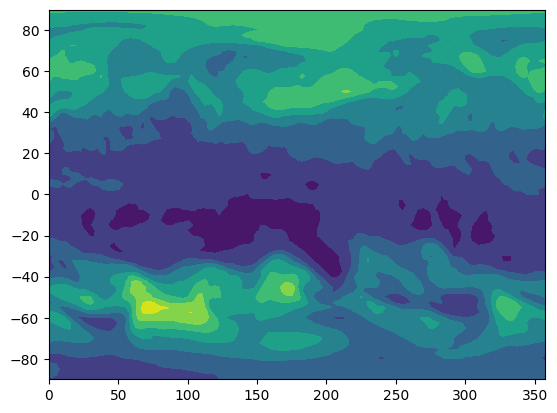

In [91]:
import numpy as np
import matplotlib.pyplot as plt
x,y = np.meshgrid(lons, lats)
plt.contourf(x,y,tco3)

## Pangeo: big data geoscience

NetCDF is a flexible and widely-used format.  However, as datasets grow larger, there is increasing demand for tools to process in parallel (as described in the previous notebook), and on the cloud.  _Pangeo_ (https://pangeo.io/index.html) is a community developing a suite of open source packages, all based on Python, that aim to provide interoperability between running on a quick study on a local machine, and running over a huge dataset in the cloud.   A major component of this is _Dask_, which we have already seen, and some others are:
* _XArray_: an `xarray.Dataset` is an in-memory representation of a _netCDF_ file, while the underlying data structures can either by _numpy_ arrays, or _Dask_ arrays.
* "Cloud native" file formats, such as _TileDB_ and _zarr_, which can both store N-dimensional arrays with intelligent chunking for either local or cloud-based access.
* _Jupyter_: interactive notebooks such as Pangeo are a convenient way for users to interact with computing resources, whether running on their local machine, or on a "hub" hosted on the cloud or an HPC cluster, the user experience, and the code, can be almost exactly the same.